In [ ]:
!pip install -qU transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.9 MB/s eta 0:00:00


# BLIP



- https://github.com/huggingface/transformers/blob/main/src/transformers/models/blip/modeling_blip.py
- https://huggingface.co/Salesforce/blip-vqa-base/tree/main

In [ ]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering
import torch

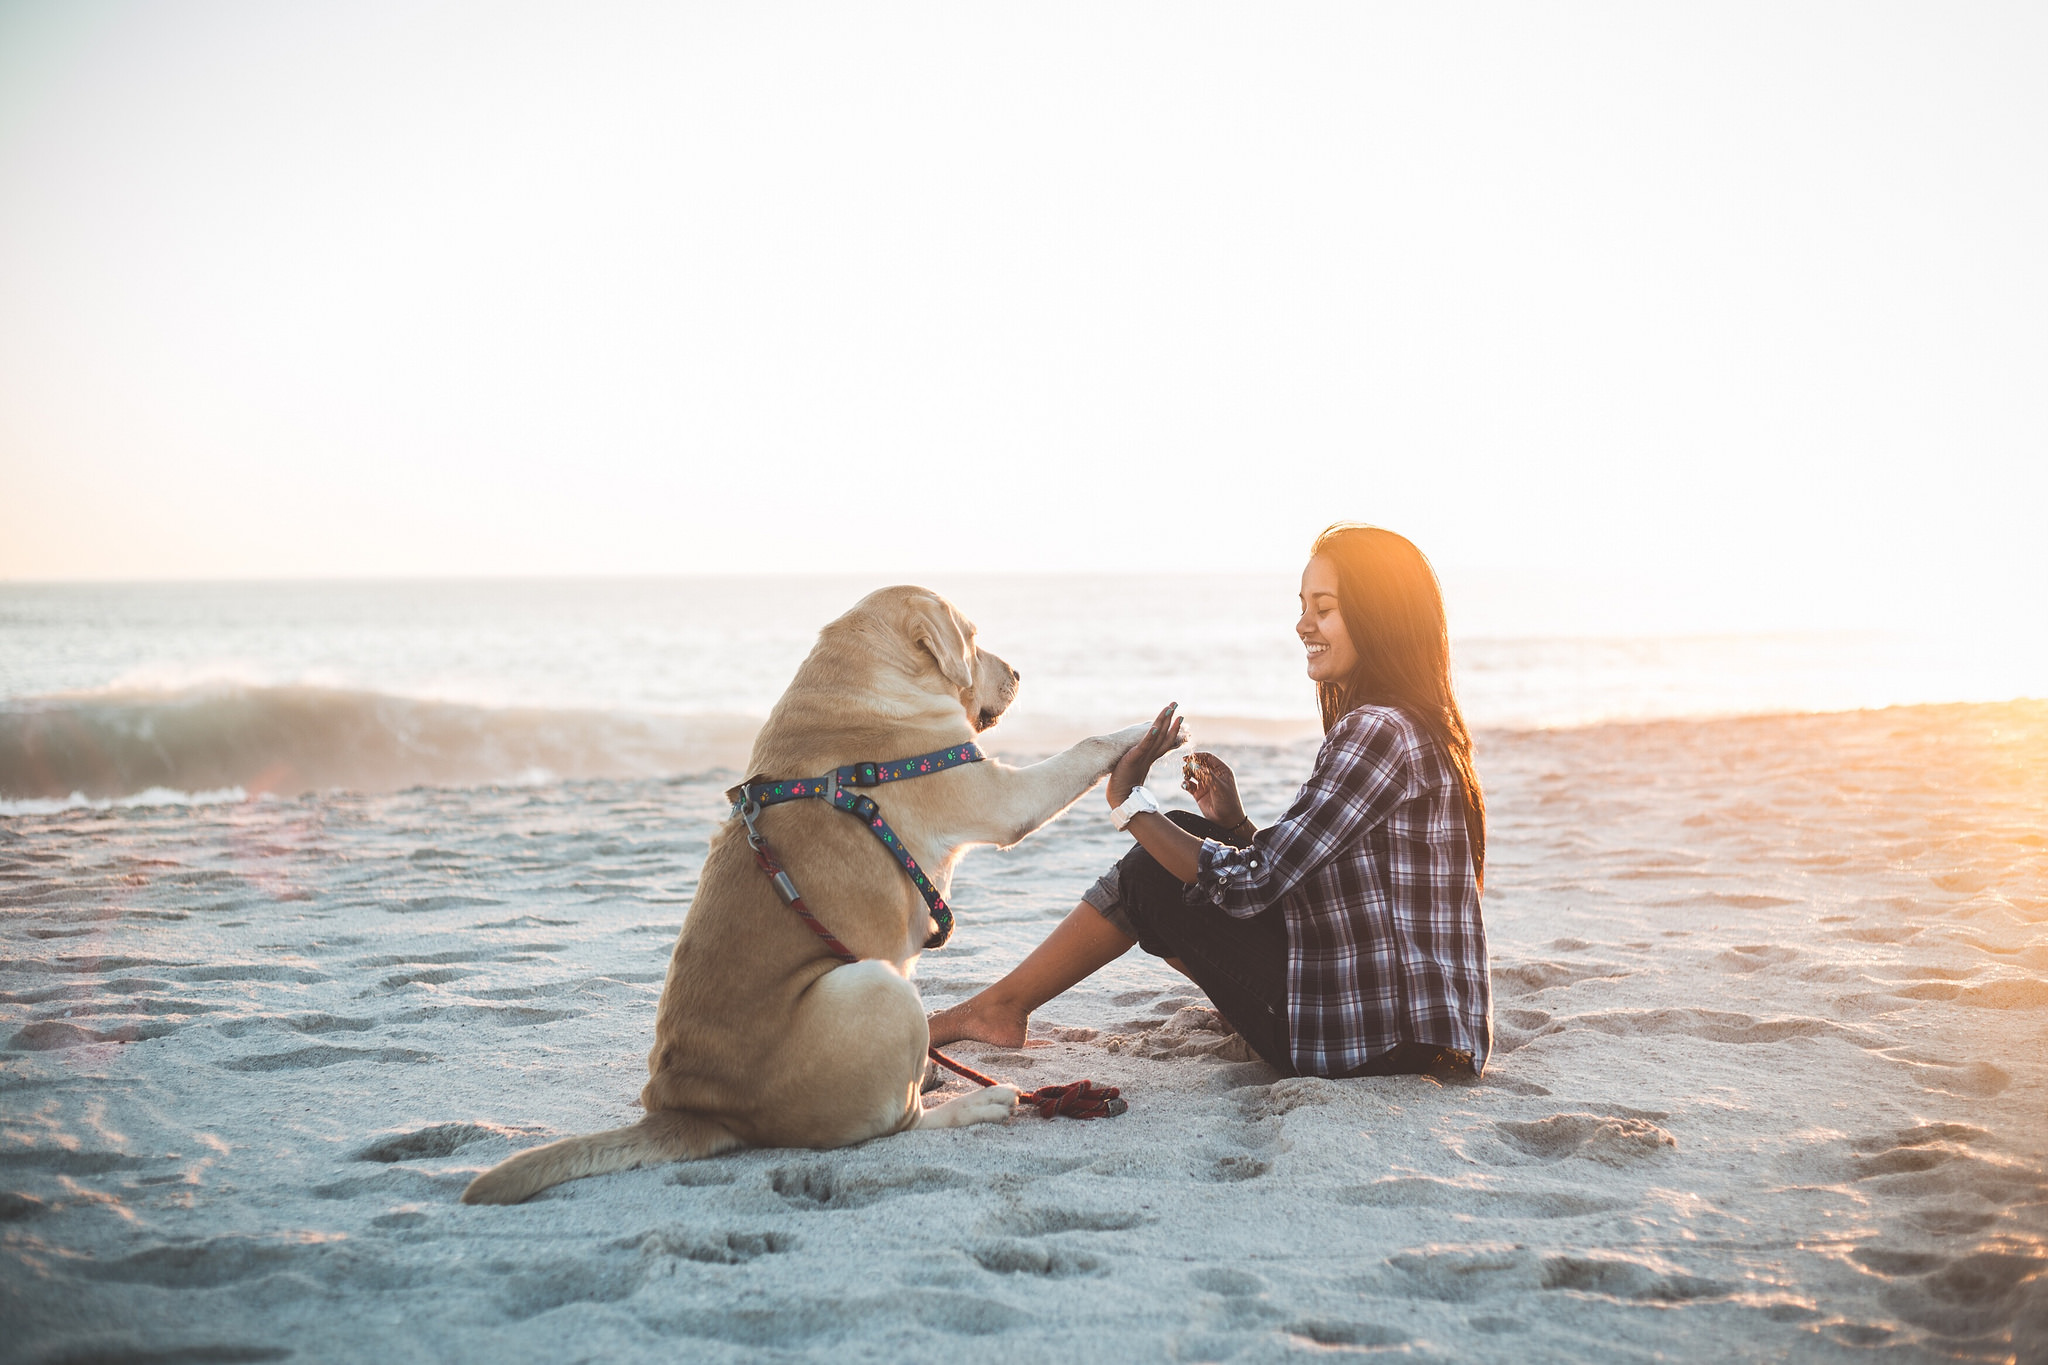

In [ ]:
# load the image we will test BLIP on
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

In [ ]:
# load necessary components: the processor and the model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

In [ ]:
def get_answer_blip(model, processor, image, question):
    """Answers the given question and handles all the preprocessing and postprocessing steps"""
    # preprocess the given image and question
    inputs = processor(image, question, return_tensors="pt")
    # generate the answer (get output)
    out = model.generate(**inputs)
    # post-process the output to get human friendly english text
    print(processor.decode(out[0], skip_special_tokens=True))
    return

In [ ]:
# sample question 1
question = "how many dogs are in the picture?"
get_answer_blip(model, processor, image, question)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


1


In [ ]:
# sample question 2
question = "how will you describe the picture?"
get_answer_blip(model, processor, image, question)

woman and dog


In [ ]:
# sample question 3
question = "where are they?"
get_answer_blip(model, processor, image, question)

beach


In [ ]:
# sample question 4
question = "What are they doing?"
get_answer_blip(model, processor, image, question)

sitting


In [ ]:
# sample question 5
question = "What the dog is wearing?"
get_answer_blip(model, processor, image, question)

harness


In [ ]:
class BLIP_VQA:
    """Custom implementation of the BLIP model. The code has been adapted from the official transformers implementation"""

    def __init__(self, vision_model, text_encoder, text_decoder, processor):
        """Initialize various objects"""
        self.vision_model = vision_model
        self.text_encoder = text_encoder
        self.text_decoder = text_decoder
        self.processor = processor

    def preprocess(self, img, ques):
        """preprocess the inputs: image, question"""
        # preprocess using the processor
        inputs = self.processor(img, ques, return_tensors='pt')
        # store the pixel values of the image, input IDs (i.e., token IDs) of the question and the attention masks separately
        pixel_values = inputs['pixel_values']
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        return pixel_values, input_ids, attention_mask


    def generate_output(self, pixel_values, input_ids, attention_mask):
        """Generates output from the preprocessed input"""

        # get the vision outputs (i.e., the image embeds)
        vision_outputs = self.vision_model(pixel_values=pixel_values)
        img_embeds = vision_outputs[0]

        # create attention mask with 1s on all the image embedding positions
        img_attention_mask = torch.ones(img_embeds.size()[: -1], dtype=torch.long)

        # encode the questions
        question_outputs = self.text_encoder(input_ids=input_ids,
                                             attention_mask=attention_mask,
                                             encoder_hidden_states=img_embeds,
                                             encoder_attention_mask=img_attention_mask,
                                             return_dict=False)

        # create attention mask with 1s on all the question token IDs positions
        question_embeds = question_outputs[0]
        question_attention_mask = torch.ones(question_embeds.size()[:-1], dtype=torch.long)

        # initialize the answers with the beginning-of-sentence IDs (bos ID)
        bos_ids = torch.full((question_embeds.size(0), 1), fill_value=30522)

        # get output from the decoder. These outputs are the generated IDs
        outputs = self.text_decoder.generate(
            input_ids=bos_ids,
            eos_token_id=102,
            pad_token_id=0,
            encoder_hidden_states=question_embeds,
            encoder_attention_mask=question_attention_mask)

        return outputs


    def postprocess(self, outputs):
        """post-process the output generated by the text-decoder"""

        return self.processor.decode(outputs[0], skip_special_tokens=True)


    def get_answer(self, image, ques):
        """Returns human friendly answer to a question"""

        # preprocess
        pixel_values, input_ids, attention_mask = self.preprocess(image, ques)
        # generate output
        outputs = self.generate_output(pixel_values, input_ids, attention_mask)
        # post-process
        answer = self.postprocess(outputs)
        return answer

In [ ]:
blip_vqa = BLIP_VQA(vision_model=model.vision_model,
                    text_encoder=model.text_encoder,
                    text_decoder=model.text_decoder,
                    processor=processor)

In [ ]:
# sample question 1
ques = "how will you describe the picture?"
print(blip_vqa.get_answer(image, ques))


woman and dog


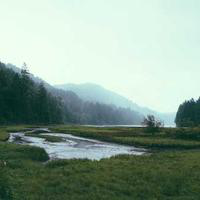

In [ ]:
# load another image to test BLIP
img_url = "https://fastly.picsum.photos/id/11/200/200.jpg?hmac=LBGO0uEpEmAVS8NeUXMqxcIdHGIcu0JiOb5DJr4mtUI"
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

In [ ]:
# sample question 1
ques = "Describe the picture"
print(blip_vqa.get_answer(image, ques))


scenic


In [ ]:
# sample question 2
ques = "What is the major color present?"
print(blip_vqa.get_answer(image, ques))


green


In [ ]:
# sample question 3
ques = "How's the weather?"
print(blip_vqa.get_answer(image, ques))

cloudy


# GIT

- https://github.com/huggingface/transformers/blob/main/src/transformers/models/git/modeling_git.py
- https://huggingface.co/microsoft/git-base-textvqa

In [ ]:
!pip install -qU transformers

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from huggingface_hub import hf_hub_download
from PIL import Image

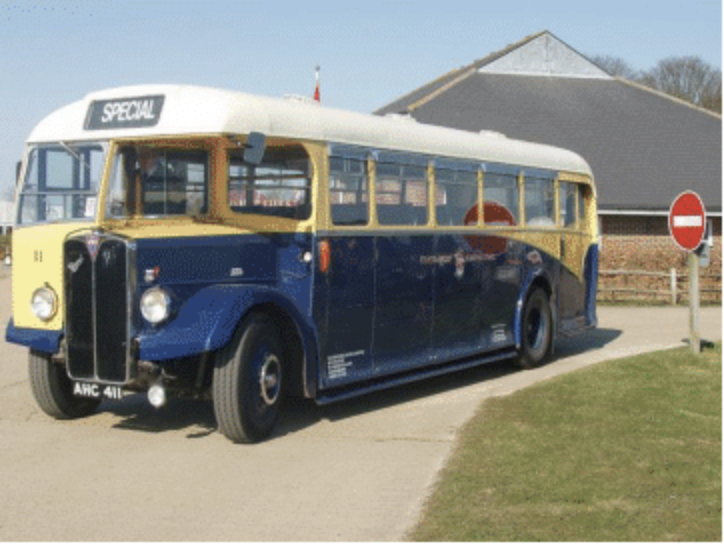

In [ ]:
# load the image we will test GIT on
file_path = hf_hub_download(repo_id="nielsr/textvqa-sample", filename="bus.png", repo_type="dataset")
image = Image.open(file_path).convert("RGB")
image

In [ ]:
# load necessary components: the processor and the model
processor = AutoProcessor.from_pretrained("microsoft/git-base-textvqa")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textvqa")

In [ ]:
class GIT_VQA:
    """Custom implementation of the GIT model for Visual Question Answering (VQA) tasks."""

    def __init__(self, model, processor):
        """Initializes the model and the processor."""
        self.model = model
        self.processor = processor
        return


    def preprocess(self, image, question):
        """Preprocesses the inputs: image, question"""
        # process the image to get pixel values
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values

        # process the question to get input IDs, but do not add special tokens
        input_ids = self.processor(text=question, add_special_tokens=False).input_ids

        # add the CLS token at the beginning of the input_ids and format for model input
        input_ids = [self.processor.tokenizer.cls_token_id] + input_ids
        input_ids = torch.tensor(input_ids).unsqueeze(0)

        return pixel_values, input_ids


    def generate(self, pixel_values, input_ids):
        """Generates the output from the preprocessed inputs."""

        # generate output using the model with a maximum length of 50 tokens
        outputs = self.model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)
        return outputs


    def postprocess(self, outputs):
        """Post-processes the output generated by the model."""

        # decode the output, ignoring special tokens
        answer = self.processor.batch_decode(outputs, skip_special_tokens=True)
        return answer


    def get_answer(self, image, question):
        """Returns human friendly answer to a question"""

        # preprocess
        pixel_values, input_ids = self.preprocess(image, question)
        # generate output
        outputs = self.generate(pixel_values, input_ids)
        # post-process
        answer = self.postprocess(outputs)
        return answer

In [ ]:
# create a GIT instance
git_vqa = GIT_VQA(model=model, processor=processor)

In [ ]:
# sample question 1
question = "what does the front of the bus say at the top?"
answer = git_vqa.get_answer(image, question)
print(answer)

['what does the front of the bus say at the top? special']


In [ ]:
# sample question 2
question = "what are all the colors present on the bus?"
answer = git_vqa.get_answer(image, question)
print(answer)

['what are all the colors present on the bus? unanswerable']


In [ ]:
# sample question 3
question = "How many wheels you see in the bus?"
answer = git_vqa.get_answer(image, question)
print(answer)

['how many wheels you see in the bus? 500']


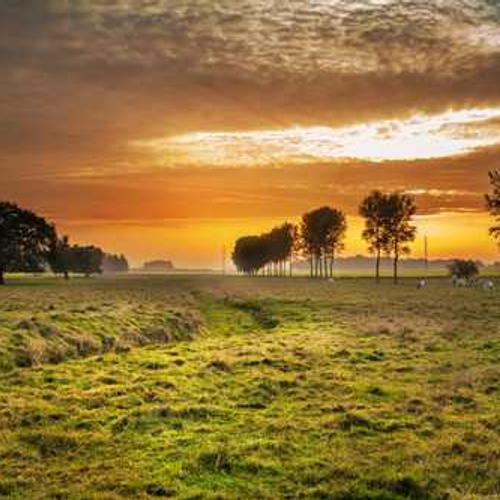

In [ ]:
# load another image to test BLIP
img_url = "https://fastly.picsum.photos/id/110/500/500.jpg?hmac=wSHhLFNyJ6k3uM94s6etGQ0WWhmwbdUSiZ9ZDL5Hh2Q"
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

In [ ]:
# sample question 1
question = "Is it night in the image?"
answer = git_vqa.get_answer(image, question)
print(answer)

['is it night in the image? no']
